In [1]:
from __future__ import print_function
import glob
from itertools import chain
import os
import random
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm,tqdm_notebook
import albumentations as A
from albumentations.pytorch import ToTensorV2

from modelli import *


In [2]:
print(f"Torch: {torch.__version__}")

Torch: 2.0.0.dev20221215+cu117


In [3]:
# Training settings
batch_size = 32
epochs = 50
lr = 3e-5
gamma = 0.7
seed = 42
re_mean_sd=False
image_size = 224


In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Data stream

In [6]:
os.makedirs('data', exist_ok=True)
images_dir = 'images/images'
train_list = glob.glob(os.path.join(images_dir,'*/*.jpg'))
print(f"Number of total images: {len(train_list)}")

#split train and validation and test
train_list, test_list = train_test_split(train_list, test_size=0.1, random_state=seed)
train_list, val_list = train_test_split(train_list, test_size=0.1, random_state=seed)

print(f"Number of train images: {len(train_list)}")
print(f"Number of validation images: {len(val_list)}")
print(f"Number of test images: {len(test_list)}")

labels = [os.path.split(os.path.split(path)[0])[1] for path in train_list]
# kkep only unique labels
labels = list(set(labels))
print("The labels are:" ,labels)


Number of total images: 8446
Number of train images: 6840
Number of validation images: 761
Number of test images: 845
The labels are: ['Henri_Matisse', 'Mikhail_Vrubel', 'Peter_Paul_Rubens', 'Andrei_Rublev', 'Caravaggio', 'Georges_Seurat', 'Kazimir_Malevich', 'El_Greco', 'William_Turner', 'Henri_Rousseau', 'Paul_Cezanne', 'Sandro_Botticelli', 'Diego_Velazquez', 'Salvador_Dali', 'Edouard_Manet', 'Diego_Rivera', 'Pierre-Auguste_Renoir', 'Joan_Miro', 'Jan_van_Eyck', 'Rembrandt', 'Albrecht_Durer', 'Giotto_di_Bondone', 'Edvard_Munch', 'Raphael', 'Amedeo_Modigliani', 'Titian', 'Hieronymus_Bosch', 'Gustave_Courbet', 'Gustav_Klimt', 'Pieter_Bruegel', 'Rene_Magritte', 'Michelangelo', 'Jackson_Pollock', 'Piet_Mondrian', 'Henri_de_Toulouse-Lautrec', 'Andy_Warhol', 'Eugene_Delacroix', 'Vasiliy_Kandinskiy', 'Claude_Monet', 'Pablo_Picasso', 'Paul_Gauguin', 'Francisco_Goya', 'Camille_Pissarro', 'Frida_Kahlo', 'Vincent_van_Gogh', 'Paul_Klee', 'Alfred_Sisley', 'Leonardo_da_Vinci', 'Edgar_Degas', 'Marc_

6840
[ 861 5391 5227 5192 3773 3093 5735 6266  467]


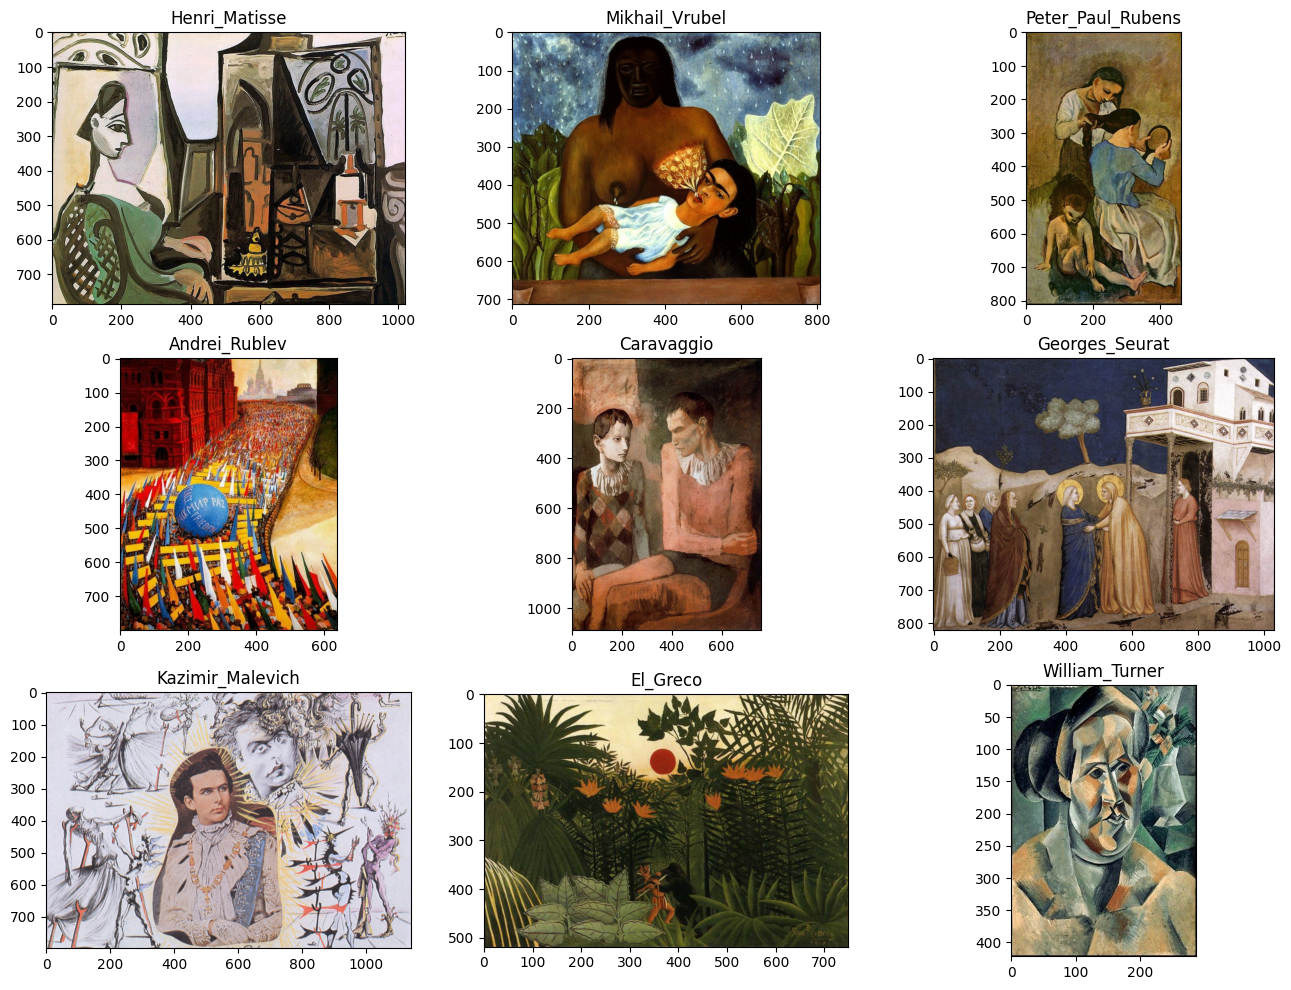

In [7]:
print(len(train_list))
random_idx = np.random.randint(1, len(train_list), size=9)
print(random_idx)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [8]:
if re_mean_sd:
    #extract mean and std from train set
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])
    train_dataset = datasets.ImageFolder(images_dir, transform=train_transform)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

    mean = 0.
    std = 0.
    nb_samples = 0.
    for data, _ in tqdm(train_loader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
else:
    mean = [0.5035, 0.4448, 0.3722]
    std =  [0.2078, 0.1935, 0.1769]
print(f"mean: {mean}")
print(f"std: {std}")


mean: [0.5035, 0.4448, 0.3722]
std: [0.2078, 0.1935, 0.1769]


In [9]:

train_transforms = A.Compose(
    [
        A.augmentations.geometric.resize.Resize (image_size, image_size, interpolation=1, always_apply=False, p=1),
        A.augmentations.Normalize(mean=mean, std=std),
        A.augmentations.geometric.rotate.RandomRotate90(),
        A.augmentations.geometric.resize.Resize (image_size, image_size, interpolation=1, always_apply=False, p=1),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        A.augmentations.geometric.resize.Resize (image_size, image_size, interpolation=1, always_apply=False, p=1),
        A.augmentations.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)


test_transforms = A.Compose(
    [
        A.augmentations.geometric.resize.Resize (image_size, image_size, interpolation=1, always_apply=False, p=1),
        A.augmentations.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)


In [10]:
class Create_dataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        # convert image to numpy array
        img = np.array(img)
        #if it is a grayscale image, repeat it 3 times
        if len(img.shape) == 2:
            img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
        # apply transforms
        img = self.transform(image=img)
        img = img['image']
        #cast to tensor
        #if it is a grayscale image, repeat it 3 times

        label = os.path.split(os.path.split(img_path)[0])[1]
        # map label to index of labels
        label = labels.index(label)
        return img, label


In [11]:
# create dataset
train_dataset = Create_dataset(train_list, transform=train_transforms)
val_dataset = Create_dataset(val_list, transform=val_transforms)
test_dataset = Create_dataset(test_list, transform=test_transforms)

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# check the dataloader
for batch_idx, (data, target) in enumerate(train_loader):
    print(data.shape)
    print(target.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [12]:
# print the sizes of train, validation and test
print(f"Train size: {len(train_loader.dataset)}")
print(f"Validation size: {len(val_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")

Train size: 6840
Validation size: 761
Test size: 845


In [13]:
torch.cuda.empty_cache()
# model
# import models from torchvision
import torchvision.models as models
#model = models.resnet50(weights=None)
from resnet import *
model = ResNet50(num_classes=len(labels))
#model = CNN_Luca_Massi(num_classes=len(labels))
# change the last layer
#model.fc = nn.Linear(2048, len(labels))
#model.fc = nn.Linear(512, len(labels))

model = model.to(device)
model = torch.compile(model)


# loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
# optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

C:\users\lucaz\appdata\local\programs\python\python39\lib\site-packages\torch\_dynamo\eval_frame.py:433: UserWarning: Windows is not currently supported, torch._dynamo.optimize() will do nothing
  warnings.warn(


In [14]:
name="kernel_3"
best_accuracy = 0
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):

        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(val_loader):

            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(val_loader)
            epoch_val_loss += val_loss / len(val_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    if epoch_val_accuracy > best_accuracy:
        best_accuracy = epoch_val_accuracy
        filename="./trained_models/"+str(name)+"/best.pt"
        torch.save(model.state_dict(), filename)
    filename="./trained_models/"+str(name)+"/last.pt"
    torch.save(model.state_dict(), filename)    

  3%|██▎                                                                               | 6/214 [00:10<05:49,  1.68s/it]


KeyboardInterrupt: 

In [ ]:
print("Predictions: ")
#import classification report
from sklearn.metrics import classification_report
# load the best model
model.load_state_dict(torch.load("./trained_models/"+str(name)+"/best.pt"))
model.eval()
# make predictions and extract the classificaiton report
y_pred = []
y_true = []
for data, label in tqdm(test_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        y_pred.extend(output.argmax(dim=1).cpu().numpy())
        y_true.extend(label.cpu().numpy())
print(classification_report(y_true, y_pred, target_names=labels))
